# Applying BiT model

In [1]:
import os
import matplotlib.pyplot as plt
import clip
import torch
from torchvision.datasets import CIFAR100
import numpy as np
import PIL
import tensorflow as tf
#import tensorflow_datasets as tfds
%matplotlib inline

#Had OpenMPI issue
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%load_ext autoreload
%autoreload 2

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
import tensorflow_hub as hub

# Load model fine-tuned on ImageNet
model_url = "https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1"
imagenet_module = hub.KerasLayer(model_url)

In [3]:
#@title Construct imagenet logit-to-class-name dictionary (imagenet_int_to_str)

#!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt

imagenet_int_to_str = {}

with open('ilsvrc2012_wordnet_lemmas.txt', 'r') as f:
    for i in range(1000):
        row = f.readline()
        row = row.rstrip()
        imagenet_int_to_str.update({i: row})

In [4]:
#@title Helper functions for loading image (hidden)
#https://colab.research.google.com/github/google-research/big_transfer/blob/master/colabs/big_transfer_tf2.ipynb#scrollTo=ewOVUVsvnSpo
def preprocess_image(image):
    image = np.array(image)
    # reshape into shape [batch_size, height, width, num_channels]
    img_reshaped = tf.reshape(image, [1, image.shape[0], image.shape[1], image.shape[2]])
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    image = tf.image.convert_image_dtype(img_reshaped, tf.float32)  
    return image

In [10]:
# Show the MAX_PREDS highest scoring labels:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.8 

def show_preds(logits, image, correct_flowers_label=None, tf_flowers_logits=False):

    if len(logits.shape) > 1:
        logits = tf.reshape(logits, [-1])

    fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

    ax1, ax2 = axes[0]

    ax1.axis('off')
    ax1.imshow(image)
    if correct_flowers_label is not None:
        ax1.set_title(tf_flowers_labels[correct_flowers_label])
    classes = []
    scores = []
    logits_max = np.max(logits)
    softmax_denominator = np.sum(np.exp(logits - logits_max))
    for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
        score = 1.0/(1.0 + np.exp(-logits[j]))
#        if score < MIN_SCORE: break
        if not tf_flowers_logits:
            # predicting in imagenet label space
            classes.append(imagenet_int_to_str[j])
        else:
            # predicting in tf_flowers label space
            classes.append(tf_flowers_labels[j])
        scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)

    ax2.barh(np.arange(len(scores)) + 0.1, scores)
    ax2.set_xlim(0, 100)
    ax2.set_yticks(np.arange(len(scores)))
    ax2.yaxis.set_ticks_position('right')
    ax2.set_yticklabels(classes, rotation=0, fontsize=14)
    ax2.invert_xaxis()
    ax2.invert_yaxis()
    ax2.set_xlabel('Prediction probabilities', fontsize=11)

## First test with constellation image

In [6]:
# Load constellations and pick one
from dataUtils import * 
pictures = loadConstellations(pictureTypes=["original", "final_easy", "outline"])

Using TensorFlow backend.


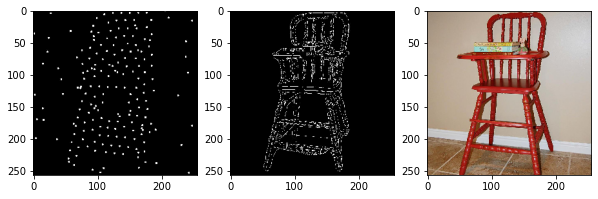

In [20]:
### Visualize selected image and its original
imageIdx = 6
objectId = list(pictures.keys())[imageIdx]
constellationImage = pictures[objectId]["final_easy"][0]
outlineImage = pictures[objectId]["outline"][0]
originalImage = pictures[objectId]["original"][0]

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))
ax1.imshow(constellationImage)
ax2.imshow(outlineImage)
ax3.imshow(originalImage)

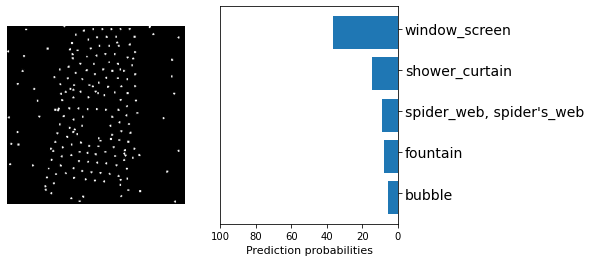

In [23]:
img = preprocess_image(constellationImage)
# use model
logits = imagenet_module(img)
# Show image and predictions
show_preds(logits, img[0])

In [11]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
#model, preprocess = clip.load('ViT-B/32', device)
model, preprocess = clip.load('RN50x4', device)
# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

Files already downloaded and verified


object_196


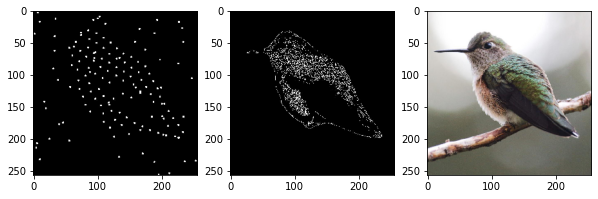


Top predictions for outline :

           whale: 40.70%
         dolphin: 21.38%
           shrew: 8.40%
       cockroach: 4.37%
             ray: 3.14%

Top predictions for final_easy :

            road: 6.83%
       pine_tree: 4.05%
             ray: 3.77%
           house: 3.72%
        keyboard: 3.69%
object_201


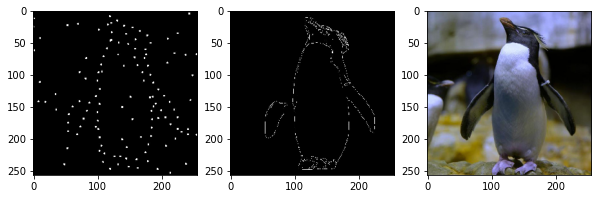


Top predictions for outline :

            pear: 36.41%
          beetle: 8.70%
        elephant: 5.18%
            crab: 5.13%
       cockroach: 4.34%

Top predictions for final_easy :

      lawn_mower: 8.99%
       palm_tree: 6.09%
        keyboard: 5.07%
            road: 4.85%
       telephone: 4.58%
object_206


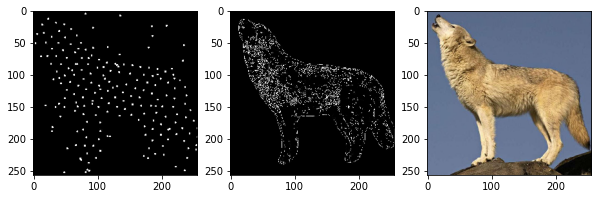


Top predictions for outline :

            wolf: 29.94%
             fox: 13.02%
            bear: 10.72%
          cattle: 10.36%
      lawn_mower: 5.78%

Top predictions for final_easy :

            road: 6.98%
       pine_tree: 5.27%
          cattle: 5.05%
       palm_tree: 3.84%
      maple_tree: 3.65%
object_211


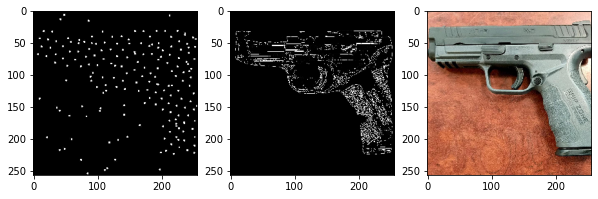


Top predictions for outline :

    pickup_truck: 10.26%
          bottle: 6.66%
      lawn_mower: 5.68%
          cattle: 5.11%
          beetle: 4.07%

Top predictions for final_easy :

            road: 17.68%
          forest: 7.59%
        keyboard: 4.33%
       pine_tree: 3.89%
           plain: 3.66%
object_225


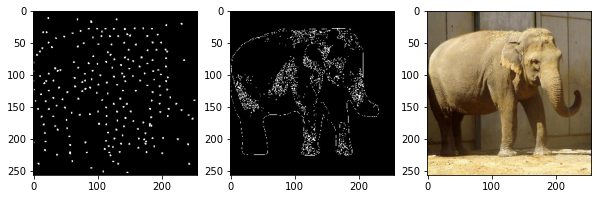


Top predictions for outline :

        elephant: 98.14%
      lawn_mower: 0.29%
          cattle: 0.19%
          beetle: 0.17%
        dinosaur: 0.17%

Top predictions for final_easy :

            road: 11.53%
      television: 6.47%
       pine_tree: 3.98%
           clock: 3.80%
        keyboard: 3.69%
object_229


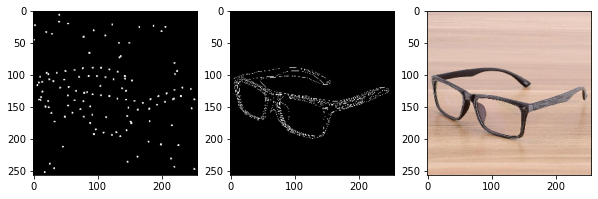


Top predictions for outline :

           trout: 8.94%
          lizard: 4.64%
        dinosaur: 4.63%
           snake: 4.58%
            girl: 4.37%

Top predictions for final_easy :

            road: 7.38%
      lawn_mower: 5.29%
        oak_tree: 4.64%
       pine_tree: 4.55%
      maple_tree: 3.58%
object_230


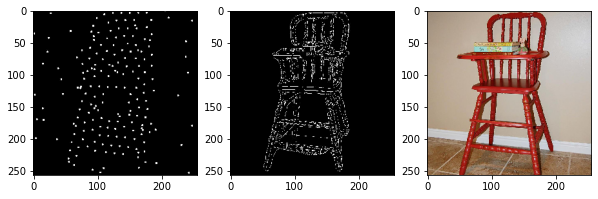


Top predictions for outline :

           chair: 85.72%
          bottle: 2.16%
      lawn_mower: 1.40%
             cup: 1.27%
           table: 1.27%

Top predictions for final_easy :

            road: 9.53%
      television: 4.85%
           clock: 4.61%
       telephone: 4.06%
      lawn_mower: 3.92%
object_234


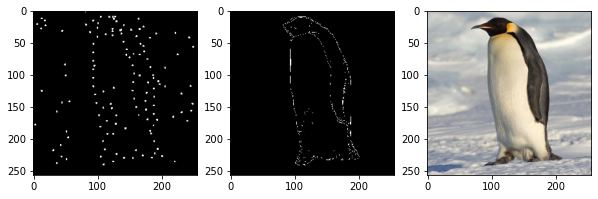


Top predictions for outline :

             ray: 9.08%
          bottle: 7.47%
           woman: 6.62%
           snake: 5.60%
        dinosaur: 4.46%

Top predictions for final_easy :

            road: 16.60%
      lawn_mower: 5.42%
      television: 4.45%
           house: 4.19%
        keyboard: 3.89%
object_243


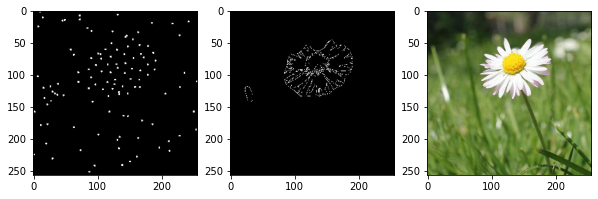


Top predictions for outline :

           poppy: 16.03%
       palm_tree: 7.96%
          spider: 4.92%
            bowl: 4.56%
           plate: 4.53%

Top predictions for final_easy :

            road: 12.65%
          forest: 4.95%
           table: 4.67%
           plain: 4.57%
        keyboard: 4.54%
object_244


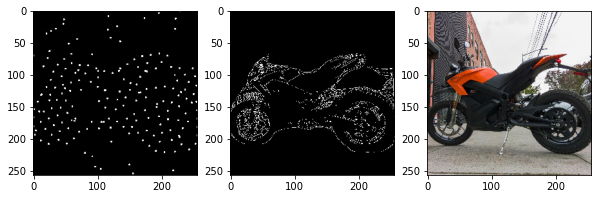


Top predictions for outline :

      motorcycle: 93.45%
         bicycle: 3.78%
           snake: 0.38%
      lawn_mower: 0.36%
            crab: 0.28%

Top predictions for final_easy :

            road: 5.80%
       pine_tree: 4.54%
      lawn_mower: 3.99%
        keyboard: 3.08%
          forest: 3.01%
object_248


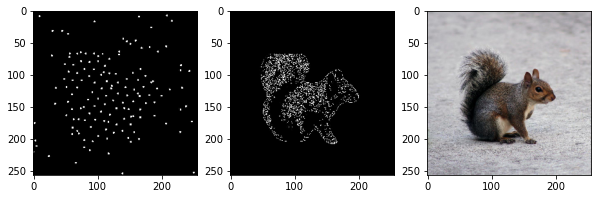


Top predictions for outline :

            bear: 25.78%
          cattle: 15.56%
        elephant: 12.75%
           mouse: 7.38%
            lion: 4.35%

Top predictions for final_easy :

            road: 11.14%
      television: 5.52%
        keyboard: 4.39%
           clock: 4.26%
      lawn_mower: 4.14%
object_256


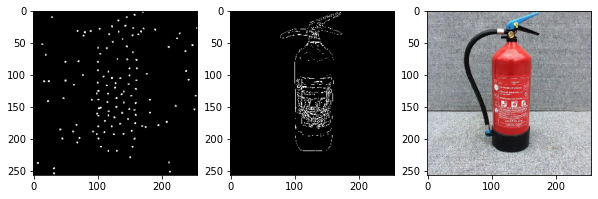


Top predictions for outline :

          bottle: 99.80%
             can: 0.08%
      lawn_mower: 0.02%
             cup: 0.02%
            lamp: 0.01%

Top predictions for final_easy :

            road: 8.88%
      lawn_mower: 6.48%
       palm_tree: 4.93%
       pine_tree: 3.91%
        oak_tree: 3.59%
object_263


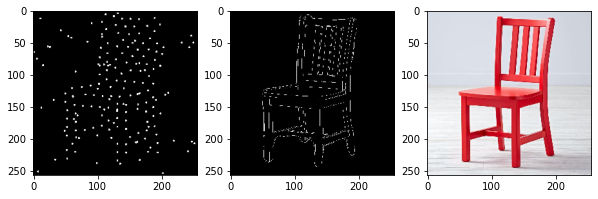


Top predictions for outline :

           chair: 99.06%
      lawn_mower: 0.29%
           table: 0.14%
           couch: 0.08%
             cup: 0.03%

Top predictions for final_easy :

            road: 7.14%
       pine_tree: 5.53%
      lawn_mower: 5.00%
      television: 4.46%
       palm_tree: 4.10%
object_266


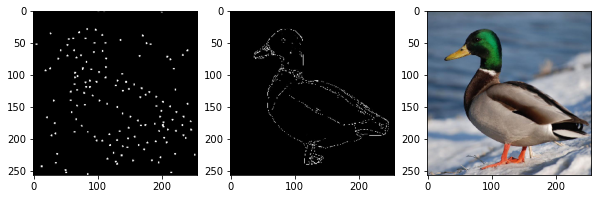


Top predictions for outline :

        dinosaur: 31.16%
       cockroach: 17.30%
      lawn_mower: 10.28%
           camel: 4.13%
          lizard: 2.79%

Top predictions for final_easy :

      lawn_mower: 7.67%
           clock: 7.23%
            road: 6.86%
       pine_tree: 4.05%
        oak_tree: 3.63%
object_322


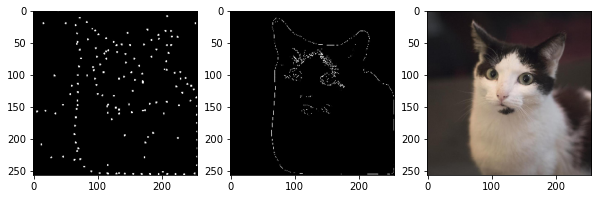


Top predictions for outline :

          bottle: 6.92%
      lawn_mower: 6.50%
             cup: 5.82%
    sweet_pepper: 5.69%
             boy: 4.73%

Top predictions for final_easy :

      lawn_mower: 12.34%
          cattle: 5.67%
       palm_tree: 3.59%
       telephone: 3.40%
       pine_tree: 3.02%
object_324


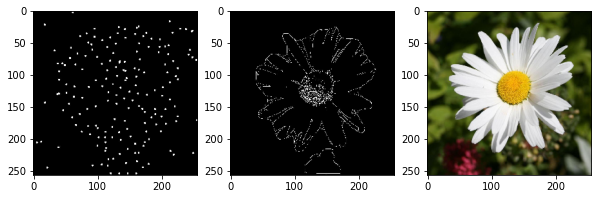


Top predictions for outline :

           poppy: 36.58%
       sunflower: 31.90%
            rose: 9.26%
           tulip: 2.69%
      lawn_mower: 2.57%

Top predictions for final_easy :

            road: 10.30%
           table: 5.53%
           clock: 4.91%
           plain: 4.54%
          forest: 4.24%
object_338


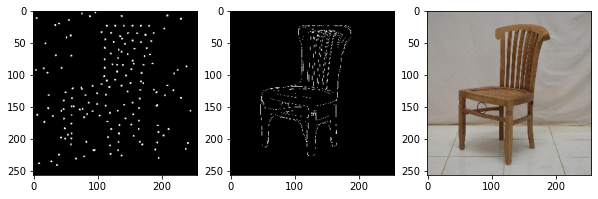


Top predictions for outline :

           chair: 99.00%
             cup: 0.26%
           table: 0.13%
           couch: 0.07%
      lawn_mower: 0.06%

Top predictions for final_easy :

            road: 8.94%
           clock: 5.12%
      lawn_mower: 4.50%
      television: 4.04%
           house: 3.98%
object_339


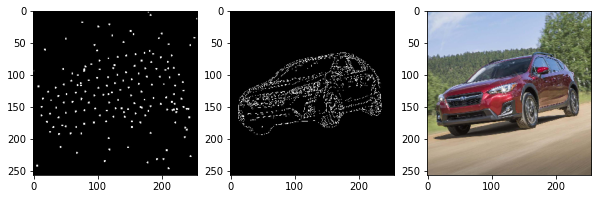


Top predictions for outline :

    pickup_truck: 30.53%
          beetle: 19.13%
      lawn_mower: 4.66%
           snake: 3.96%
           plate: 3.05%

Top predictions for final_easy :

            road: 12.08%
          forest: 5.78%
      television: 5.24%
        keyboard: 4.53%
            lamp: 3.36%
object_341


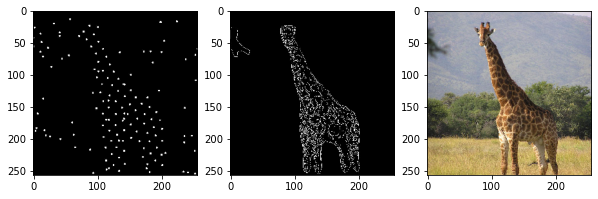


Top predictions for outline :

           camel: 26.30%
        dinosaur: 17.98%
      lawn_mower: 7.26%
        elephant: 5.91%
        kangaroo: 5.27%

Top predictions for final_easy :

            road: 11.81%
          forest: 4.45%
       pine_tree: 4.14%
      lawn_mower: 3.86%
           house: 3.71%
object_345


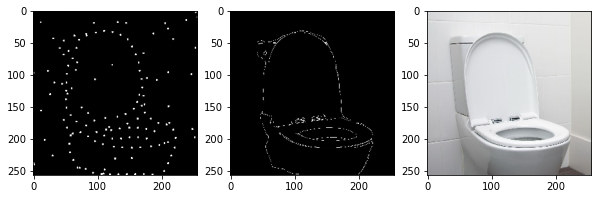


Top predictions for outline :

            bowl: 76.23%
             cup: 4.88%
           chair: 3.48%
       telephone: 1.89%
           plate: 1.75%

Top predictions for final_easy :

      lawn_mower: 13.55%
            bear: 2.86%
          cattle: 2.84%
       telephone: 2.79%
           clock: 2.72%
object_351


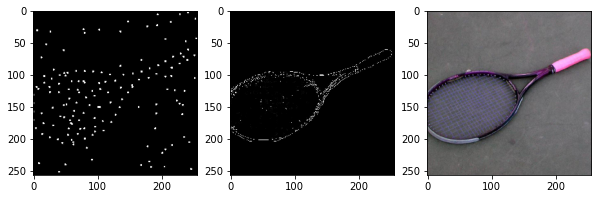


Top predictions for outline :

             ray: 10.04%
             cup: 9.30%
            bowl: 8.58%
        flatfish: 6.92%
          bottle: 5.66%

Top predictions for final_easy :

            road: 23.68%
        keyboard: 5.22%
          forest: 4.70%
           plain: 3.64%
      television: 3.52%
object_367


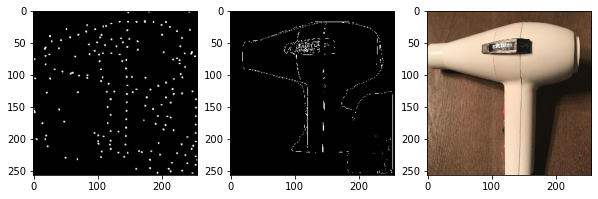


Top predictions for outline :

       telephone: 17.99%
           chair: 10.50%
        elephant: 6.66%
       palm_tree: 5.67%
      lawn_mower: 5.24%

Top predictions for final_easy :

            road: 10.51%
      lawn_mower: 6.50%
           clock: 5.54%
        keyboard: 5.48%
      television: 4.95%
object_369


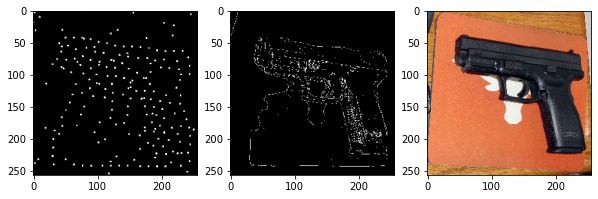


Top predictions for outline :

      lawn_mower: 15.19%
            tank: 6.27%
       telephone: 5.52%
          bottle: 5.39%
           couch: 5.28%

Top predictions for final_easy :

            road: 8.31%
      lawn_mower: 5.24%
        keyboard: 5.03%
       telephone: 3.66%
       pine_tree: 3.53%
object_385


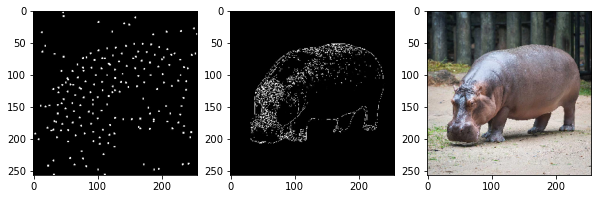


Top predictions for outline :

        elephant: 28.32%
            bear: 18.66%
          beaver: 10.34%
       porcupine: 6.21%
          cattle: 3.54%

Top predictions for final_easy :

            road: 7.92%
      lawn_mower: 4.58%
        keyboard: 4.52%
          forest: 3.96%
       palm_tree: 3.42%
object_391


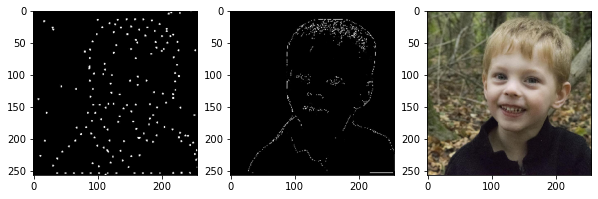


Top predictions for outline :

             boy: 26.53%
    sweet_pepper: 12.38%
            girl: 8.81%
      lawn_mower: 6.86%
             can: 4.72%

Top predictions for final_easy :

      lawn_mower: 10.48%
       palm_tree: 8.22%
       pine_tree: 6.47%
            road: 4.21%
       telephone: 3.95%
object_409


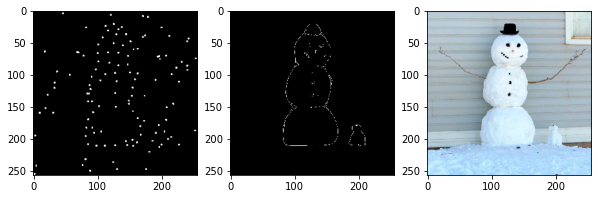


Top predictions for outline :

            bear: 20.73%
          rabbit: 8.55%
      lawn_mower: 4.92%
          bottle: 4.69%
    sweet_pepper: 4.26%

Top predictions for final_easy :

            road: 7.95%
      lawn_mower: 6.38%
           clock: 5.85%
       pine_tree: 5.24%
           house: 4.25%
object_410


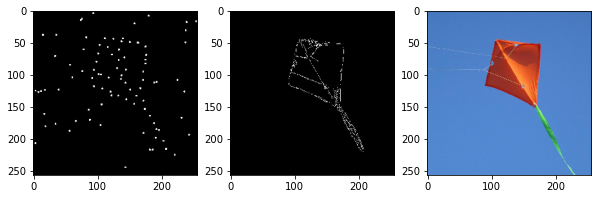


Top predictions for outline :

             ray: 10.74%
           chair: 7.62%
       butterfly: 6.70%
       palm_tree: 6.54%
      lawn_mower: 5.00%

Top predictions for final_easy :

            road: 12.07%
      lawn_mower: 8.47%
           clock: 4.61%
       telephone: 3.74%
           house: 3.45%
object_411


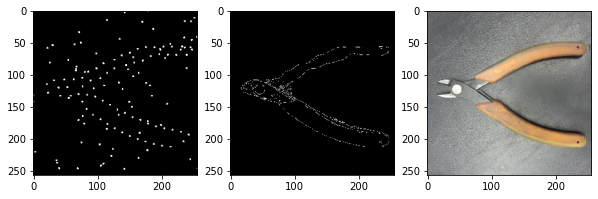


Top predictions for outline :

           snake: 30.50%
           trout: 12.94%
        flatfish: 5.25%
            worm: 4.92%
           whale: 4.87%

Top predictions for final_easy :

       palm_tree: 6.75%
      lawn_mower: 6.65%
           clock: 6.05%
      television: 4.74%
            road: 4.60%
object_412


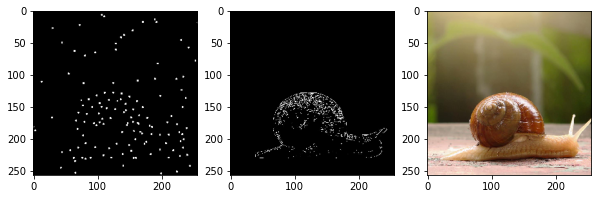


Top predictions for outline :

          turtle: 13.47%
        elephant: 9.50%
           snail: 8.61%
        dinosaur: 5.09%
          lizard: 3.06%

Top predictions for final_easy :

            road: 7.11%
       pine_tree: 6.58%
           clock: 4.70%
          forest: 4.63%
       palm_tree: 4.05%
object_413


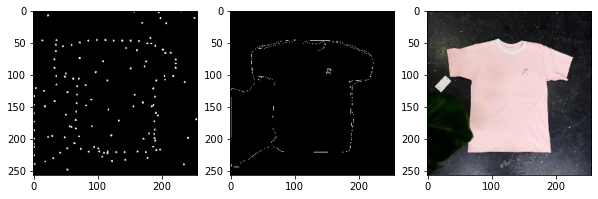


Top predictions for outline :

       telephone: 9.98%
      lawn_mower: 9.18%
        elephant: 6.89%
           whale: 6.84%
       palm_tree: 4.30%

Top predictions for final_easy :

      lawn_mower: 9.29%
            road: 6.66%
       palm_tree: 4.90%
          cattle: 4.64%
       pine_tree: 3.79%
object_419


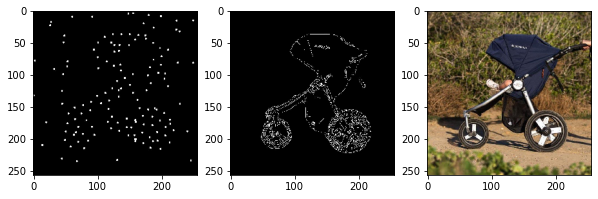


Top predictions for outline :

         bicycle: 54.66%
      lawn_mower: 17.56%
      motorcycle: 15.41%
         tractor: 1.36%
       telephone: 0.99%

Top predictions for final_easy :

            road: 10.38%
      lawn_mower: 6.86%
        keyboard: 5.12%
      television: 3.70%
       palm_tree: 3.56%
object_432


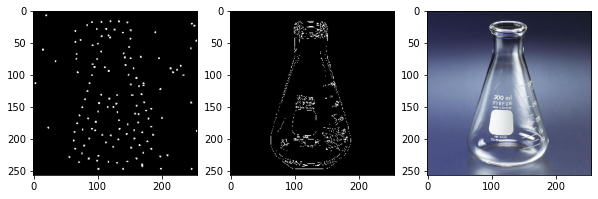


Top predictions for outline :

          bottle: 98.81%
            lamp: 0.21%
            pear: 0.18%
    sweet_pepper: 0.15%
             can: 0.12%

Top predictions for final_easy :

            road: 10.30%
      television: 5.82%
        keyboard: 5.06%
           clock: 4.91%
      lawn_mower: 4.12%
object_439


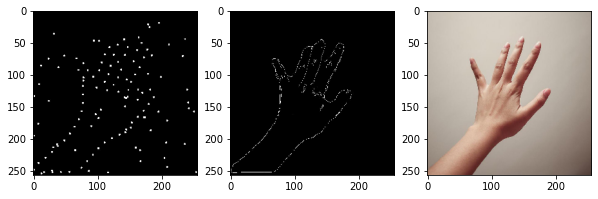


Top predictions for outline :

            girl: 12.10%
       palm_tree: 9.14%
           woman: 6.73%
             cup: 5.41%
             boy: 4.78%


In [ ]:
# Prepare the inputs
#image, class_id = cifar100[3637]
n = len(pictures.keys())

for i in range(n):
    objectId = list(pictures.keys())[i]
    constellationImage = pictures[objectId]["final_easy"][0]
    outlineImage = pictures[objectId]["outline"][0]
    originalImage = pictures[objectId]["original"][0]
    print(objectId)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))
    axes[0].imshow(constellationImage)
    axes[1].imshow(outlineImage)
    axes[2].imshow(originalImage)
    plt.show()

    for image_type in ["outline", "final_easy"]:

        image = PIL.Image.fromarray(pictures[objectId][image_type][0])
        image_input = preprocess(image).unsqueeze(0).to(device)
        text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

        # Calculate features
        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_inputs)

        # Pick the top 5 most similar labels for the image
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        values, indices = similarity[0].topk(5)

        # Print the result
        print("\nTop predictions for", image_type, ":\n")
        for value, index in zip(values, indices):
            print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")